In [1]:
import sys
sys.path.append("..")
from plot_utils import *

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.distributions import Beta
from torch.distributions.dirichlet import Dirichlet
from tqdm import tqdm
#
from utils import *
from functions import *

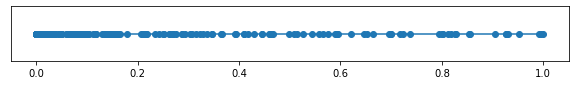

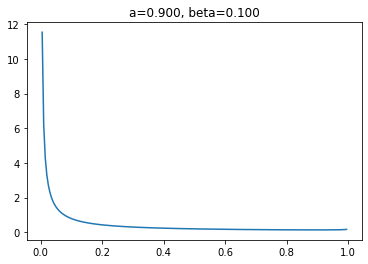

In [22]:
a, b = torch.Tensor([.1]), torch.Tensor([.9])
d = Beta(a, b)
n_samples = 500
x = d.sample((n_samples, ))
simplex_plot(x)
plot_beta_pdf(d, "True")

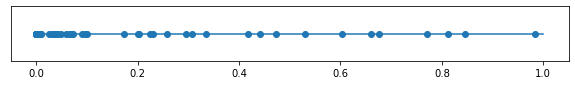

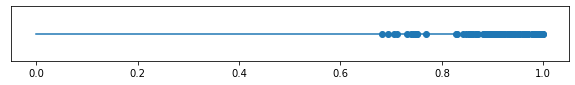

In [4]:
a1, b1 = torch.Tensor([.1]), torch.Tensor([.9])
a2, b2 = 1/a1, 1/b1
#
d1 = Beta(a1, b1)
d2 = Beta(a2, b2)
#
n_samples = 100
x1 = d1.sample((n_samples, ))
x2 = d2.sample((n_samples, ))
#
simplex_plot(x1)
simplex_plot(x2)

In [ ]:
print(kl_beta_beta_pt(d2, d1))
print(kl_beta_beta_pt(d1, d2))

In [ ]:
print(kl_beta_beta(ab_aprx=(a2, b2), ab_true=(a1, b1), forward=True))
print(kl_beta_beta(ab_aprx=(a2, b2), ab_true=(a1, b1), forward=False))

In [ ]:
n_samples = 10000
#
a_true, b_true = 0.2, 0.5
d_true = Beta(a_true, b_true)
#
d_aprx = Beta(1/b_true, 1/a_true)
x_aprx = d_aprx.sample((n_samples,))
#
a_aprx, b_aprx = beta_params(x_aprx)
a_aprx, b_aprx = 1/b_aprx, 1/a_aprx
#
print("P = Beta({:.3f},{:.3f})".format(a_true, b_true))
print("Q = Beta({:.3f},{:.3f})".format(a_aprx, b_aprx))

In [ ]:
plot_beta_pdf(d_true, title="True")
plot_beta_pdf(d_aprx, title="Approx")
plot_beta_pdf(d_aprx, title="Estimated")

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, d_in, d_out, batch_norm):
        super().__init__()
        if batch_norm:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.BatchNorm1d(d_out),
                nn.ReLU(inplace=True)
            )
        else:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.ff(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
class Net(nn.Module):
    def __init__(self, d_in, d_hid, n_hid, d_out, batch_norm=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.n_hid = n_hid
        self.d_hid = d_hid
        
        self.dims = [d_in] + [d_hid] * n_hid
        
        layers = []
        for idx in range(len(self.dims) - 1):
            layers.append(BasicBlock(self.dims[idx], self.dims[idx + 1], batch_norm))
        layers.append(nn.Linear(self.dims[-1], d_out))
        layers.append(nn.Sigmoid())
        self.backbone = nn.Sequential(*layers)
    def forward(self, x):
        return self.backbone(x)

# Beta: DKL(P_hat, Q_hat) vs DKL(P, Q)

In [ ]:
d_in = 1
d_hid = 16
d_out = 1
n_hid = 4
batch_norm = True
#
a_true, b_true = torch.Tensor([0.2, 0.8])
#
batch_size = 64
num_steps = 400
num_epochs = 10
plot_freq = 5

# DKL(Q_hat,P_hat)

In [ ]:
a_true_prox = torch.Tensor([1 / b_true])
b_true_prox = torch.Tensor([1 / a_true])
#
dist_true = Beta(a_true, b_true)
dist_true_prox = Beta(a_true_prox, b_true_prox)
#
plot_beta_pdf(dist_true, "True")
plot_beta_pdf(dist_true_prox, "Prox")
#
dist_in = torch.distributions.Uniform(0, 1)
x = dist_in.sample((100,))

In [ ]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.apply(init_weights)
x = torch.rand((512, d_in))

model.eval()
with torch.no_grad():
    z = model(x)
#
simplex_plot(z.detach().numpy())
simplex_plot(x.numpy())
print(z.min(), z.max())

In [ ]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    model.train()
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, num_epochs, 'train')
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
    epoch_loss = 0
    epoch_a = 0
    epoch_b = 0
    for step in pbar:
        x = dist_in.sample((batch_size, )).view((-1, 1))
        # ##########
        # TRAIN
        # ##########
        for param in model.parameters():
            param.grad = None
        z = model(x)
        a_z, b_z = beta_params(z)
        a_aprx_prox = 1 / b_z
        b_aprx_prox = 1 / a_z
        loss =  kl_beta_beta((a_aprx_prox,b_aprx_prox),
                                 (a_true_prox,b_true_prox),forward=True)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_a += a_z.item()
        epoch_b += b_z.item()
        pbar.set_postfix({'loss': loss.item(), 'a': a_z.item(), 'b': b_z.item()})
        #time.sleep(0.001)
    all_loss.append(epoch_loss / num_steps)
    all_a.append(epoch_a / num_steps)
    all_b.append(epoch_b / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x = dist_in.sample((batch_size, )).view((-1, 1))
            z = model(x)
            #
            a_z, b_z = beta_params(z)
            dist_aprx = Beta(a_z, b_z)
            plot_beta_pdf(dist_aprx, "aprx")

In [ ]:
xx = range(num_epochs)
plt.plot(xx, all_loss)
plt.show()
plt.plot(xx, np.abs(np.array(all_a) - a_true.numpy()))
plt.plot(xx, np.abs(np.array(all_b) - b_true.numpy()))
plt.yscale("log")

In [ ]:
model.eval()
n_samples = 64
with torch.no_grad():
    x = dist_in.sample((n_samples, )).view((-1, 1))
    z = model(x)
simplex_plot(z.numpy())


n_samples = 1000
with torch.no_grad():
    x = dist_in.sample((n_samples, )).view((-1, 1))
    z = model(x)

#
a_z, b_z = beta_params(z)
#
dist_aprx = Beta(a_z, b_z)
plot_beta_pdf(dist_aprx, "aprx")
#
print("pred", a_z, b_z)
print("true",a_true, b_true)

# DKL(Q,P)

In [ ]:
dist_true = Beta(a_true, b_true)
plot_beta_pdf(dist_true, "True")

In [ ]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.apply(init_weights)
x = torch.rand((512, d_in))

model.eval()
with torch.no_grad():
    z = model(x)
#
simplex_plot(z.detach().numpy())
simplex_plot(x.numpy())
print(z.min(), z.max())

In [ ]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    model.train()
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, num_epochs, 'train')
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
    epoch_loss = 0
    epoch_a = 0
    epoch_b = 0
    for step in pbar:
        x = dist_in.sample((batch_size, )).view((-1, 1))
        # ##########
        # TRAIN
        # ##########
        for param in model.parameters():
            param.grad = None
        z = model(x)
        a_z, b_z = beta_params(z)
        loss =  kl_beta_beta((a_z,b_z),
                             (a_true,b_true),forward=True)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_a += a_z.item()
        epoch_b += b_z.item()
        pbar.set_postfix({'loss': loss.item(), 'a': a_z.item(), 'b': b_z.item()})
        #time.sleep(0.001)
    all_loss.append(epoch_loss / num_steps)
    all_a.append(epoch_a / num_steps)
    all_b.append(epoch_b / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x = dist_in.sample((batch_size, )).view((-1, 1))
            z = model(x)
            #
            a_z, b_z = beta_params(z)
            dist_aprx = Beta(a_z, b_z)
            plot_beta_pdf(dist_aprx, "aprx")

In [ ]:
xx = range(num_epochs)
plt.plot(xx, all_loss)
plt.show()
plt.plot(xx, np.abs(np.array(all_a) - a_true.numpy()))
plt.plot(xx, np.abs(np.array(all_b) - b_true.numpy()))
plt.yscale("log")

In [ ]:
model.eval()
n_samples = 64
with torch.no_grad():
    x = dist_in.sample((n_samples, )).view((-1, 1))
    z = model(x)
simplex_plot(z.numpy())


n_samples = 10000
with torch.no_grad():
    x = dist_in.sample((n_samples, )).view((-1, 1))
    z = model(x)

#
a_z, b_z = beta_params(z)
#
dist_aprx = Beta(a_z, b_z)
plot_beta_pdf(dist_aprx, "aprx")
#
print("pred", a_z, b_z)
print("true",a_true, b_true)